In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Again start by downloading the neccessary data into the Colab Instance

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2021-03-01 07:22:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   198MB/s    in 0.7s    

2021-03-01 07:22:19 (198 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-03-01 07:22:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [3]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [4]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')
# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')
train_horse_names = os.listdir('/tmp/horse-or-human/horses')
print(train_horse_names[:10])
train_human_names = os.listdir('/tmp/horse-or-human/humans')
print(train_human_names[:10])
validation_horse_hames = os.listdir('/tmp/validation-horse-or-human/horses')
print(validation_horse_hames[:10])
validation_human_names = os.listdir('/tmp/validation-horse-or-human/humans')
print(validation_human_names[:10])

['horse03-2.png', 'horse26-8.png', 'horse36-8.png', 'horse23-8.png', 'horse36-3.png', 'horse12-7.png', 'horse42-6.png', 'horse19-1.png', 'horse26-3.png', 'horse03-7.png']
['human14-21.png', 'human01-07.png', 'human07-06.png', 'human07-30.png', 'human08-13.png', 'human15-03.png', 'human02-03.png', 'human17-15.png', 'human10-10.png', 'human11-30.png']
['horse6-218.png', 'horse5-032.png', 'horse4-102.png', 'horse6-544.png', 'horse5-103.png', 'horse4-548.png', 'horse4-188.png', 'horse3-416.png', 'horse5-458.png', 'horse5-060.png']
['valhuman01-00.png', 'valhuman05-06.png', 'valhuman01-06.png', 'valhuman01-20.png', 'valhuman01-16.png', 'valhuman04-22.png', 'valhuman04-15.png', 'valhuman03-24.png', 'valhuman04-20.png', 'valhuman04-14.png']


In [5]:
import tensorflow as tf

## Then again define your model and optimizer

In [6]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

## Now when we organize the data into Generators note how we use many more kinds of Data Augmentation!

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be augmented
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human',
        target_size=(300, 300),
        class_mode='binary')


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Train your model with the new augmented data
Since we now have more data due to the data augmentation this training process will take a bit longer than the last time. However, you'll find that the results are much better!

In [9]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data=validation_generator)

Epoch 1/15
8/8 [==============================] - 24s 2s/step - loss: 1.3091 - acc: 0.4863 - val_loss: 0.8058 - val_acc: 0.5000
Epoch 2/15
8/8 [==============================] - 20s 2s/step - loss: 0.7329 - acc: 0.4914 - val_loss: 0.6838 - val_acc: 0.5000
Epoch 3/15
8/8 [==============================] - 19s 2s/step - loss: 0.6881 - acc: 0.5933 - val_loss: 0.9628 - val_acc: 0.5000
Epoch 4/15
8/8 [==============================] - 19s 2s/step - loss: 0.7248 - acc: 0.5461 - val_loss: 0.6299 - val_acc: 0.8594
Epoch 5/15
8/8 [==============================] - 19s 2s/step - loss: 0.6826 - acc: 0.5900 - val_loss: 0.6759 - val_acc: 0.5039
Epoch 6/15
8/8 [==============================] - 19s 2s/step - loss: 0.6795 - acc: 0.6215 - val_loss: 0.6564 - val_acc: 0.5000
Epoch 7/15
8/8 [==============================] - 19s 2s/step - loss: 0.6763 - acc: 0.6347 - val_loss: 0.6598 - val_acc: 0.5078
Epoch 8/15
8/8 [==============================] - 19s 2s/step - loss: 0.6707 - acc: 0.5750 - val_loss: 0

## Try Running the Model Again

Can you confuse it this time? Or did the extra data augmentation help the model generalize? What do you think it was about your confusing examples that are no longer confusing (or what is still confusing)?

In [10]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

Saving horse.jpg to horse.jpg
[[0.]]
[0.]
horse.jpg is a horse


## Finally again lets visualize some of the layers for intuition

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


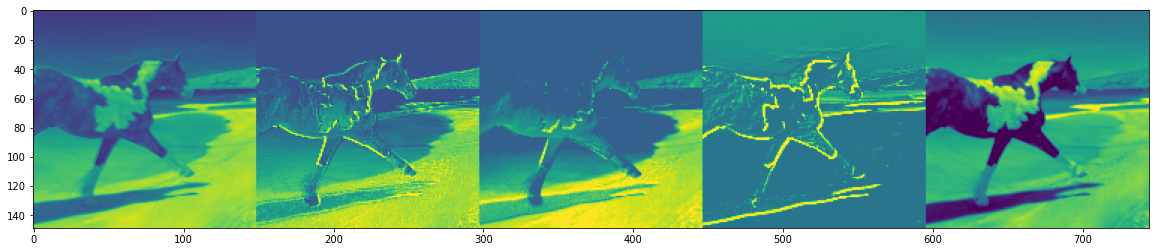

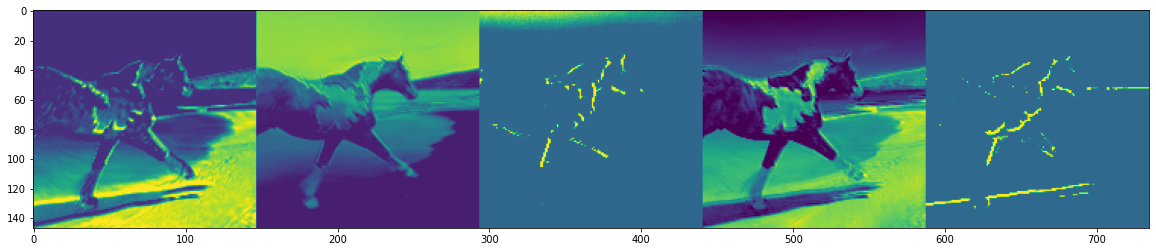

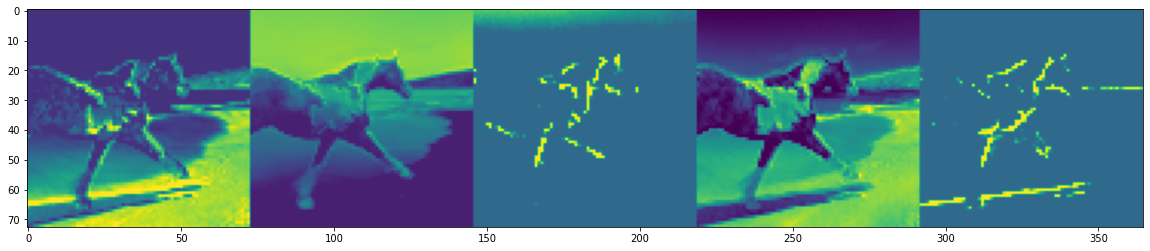

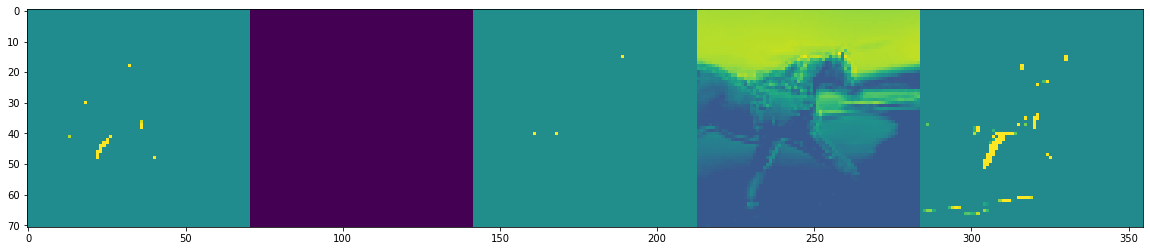

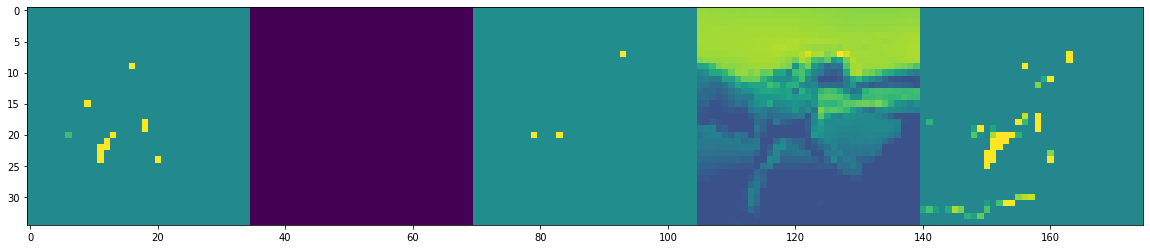

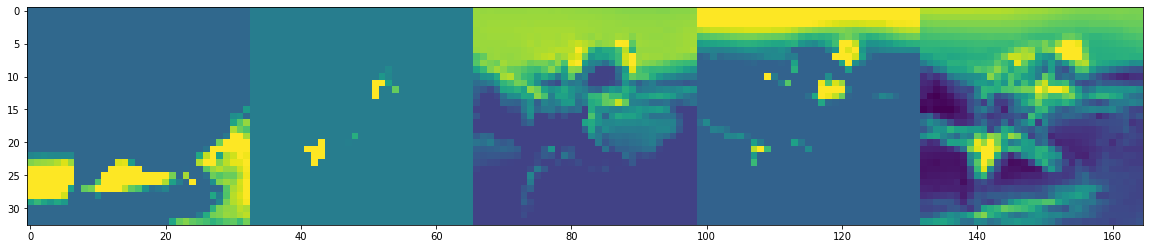

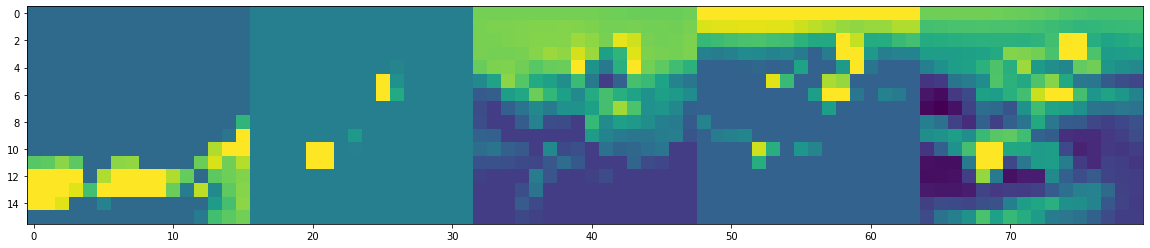

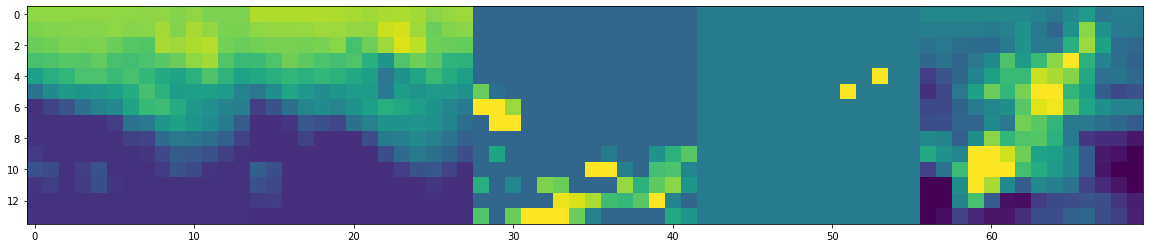

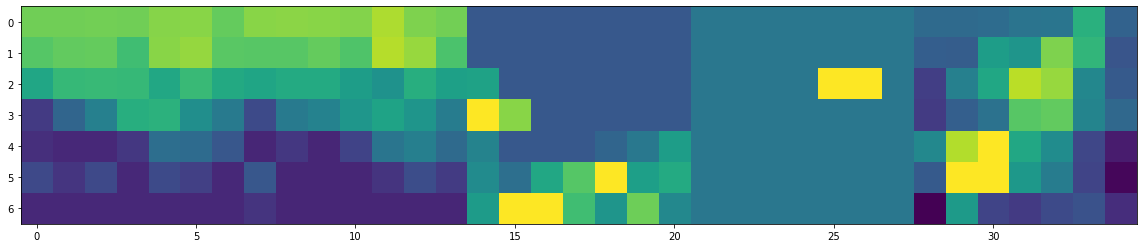

In [11]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    n_features = 5
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    #plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')